# Engineering Transparency into Your Multinomial Machine Learning Model with Python (Based on simulated data)

### Multinomial partial dependence, ICE, and Shapley explanations
In this notebook a gradient boosting machine (GBM) is trained to predict a multinomial target using a simulated dataset, Python, NumPy, Pandas, and XGBoost. First, the dataset is simulated. Then the multinomial model is trained. After the model is trained, partial dependence and individual conditional expectation (ICE) plots are used to analyze and verify the model's behavior. Finally an example of creating regulator mandated reason codes from high fidelity Shapley explanations for any model prediction is presented. This combination of partial dependence, ICE, and Shapley explanations is probably the most direct way to create an interpretable machine learning model today.

In addition to above, `eli5` and `LIME` variable importances are also presented globally and locally for comparision purposes. 

### Python imports

In [1]:
import sys
sys.path.append("../..") 

import numpy as np                   
import pandas as pd                 
import xgboost as xgb                
import shap
import eli5
import h2o
import os

import warnings
warnings.filterwarnings('ignore')

from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from lime_explainer import LIMEExplainer
from data_maker_and_getter import DataMakerAndGetter

import matplotlib.pyplot as plt
pd.options.display.max_columns = 999

%matplotlib inline

np.random.seed(12345)

cwd = os.getcwd()
print("Current working directory is " + cwd)

Current working directory is /home/ubuntu/interpretable-ml/notebooks/simulated/multinomial


In [2]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  ----------------------------------------
H2O cluster uptime:         9 hours 9 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.20.0.8
H2O cluster version age:    25 days
H2O cluster name:           H2O_from_python_ubuntu_bgyh8r
H2O cluster total nodes:    1
H2O cluster free memory:    10.38 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.3 final
--------------------------  ----------------------------------------

### Known Signal Generating Function for Simulated Data
The outcome, `y (target)`, is generated based on the following formula:

$$y = x_1 * x_4 + |x_8| * (x_9)^2$$

This indicates that `y (target)` is highly correlated to `x1`, `x4`, `x8`, and `x9` which translate to `num1`, `num4`, `num8`, and `num9` in the generated dataset below.

# Data Generation

In [3]:
ds_ = DataMakerAndGetter(nrows=30000, target='multinomial', one_function=True, noise=True, seed=12345)
data = ds_.make_random_with_signal()
data.head()

num1      num2      num3      num4      num5      num6      num7  \
0 -0.204708  0.478943 -0.519439 -0.555730  1.965781  1.393406  0.092908   
1  0.476985  3.248944 -1.021228 -0.577087  0.124121  0.302614  0.523772   
2 -1.541996 -0.970736 -1.307030  0.286350  0.377984 -0.753887  0.331286   
3  0.670216  0.852965 -0.955869 -0.023493 -2.304234 -0.652469 -1.218302   
4  1.010737  1.824875 -0.997518  0.850591 -0.131578  0.912414  0.188211   

       num8      num9     num10     num11     num12     num13     num14  \
0  0.281746  0.769023  1.246435  1.007189 -1.296221  0.274992  0.228913   
1  0.000940  1.343810 -0.713544 -0.831154 -2.370232 -1.860761 -0.860757   
2  1.349742  0.069877  0.246674 -0.011862  1.004812  1.327195 -0.919262   
3 -1.332610  1.074623  0.723642  0.690002  1.001543 -0.503087 -0.622274   
4  2.169461 -0.114928  2.003697  0.029610  0.795253  0.118110 -0.748532   

      num15     num16     num17     num18     num19     num20     num21  \
0  1.352917  0.886429 -2.001637 -0.371843  1.669025 -0.438570 -0.539741   
1  0.560145 -1.265934  0.119827 -1.063512  0.332883 -2.359419 -0.199543   
2 -1.549106  0.022185  0.758363 -0.660524  0.862580 -0.010032  0.050009   
3 -0.921169 -0.726213  0.222896  0.051316 -1.157719  0.816707  0.433610   
4  0.584970  0.152677 -1.565657 -0.562540 -0.032664 -0.929006 -0.482573   

   target  row_id  function  
0     0.0       0       1.0  
1     0.0       1       1.0  
2     0.0       2       1.0  
3     2.0       3       1.0  
4     1.0       4       1.0

### Assign modeling roles

In [4]:
#Assign target and inputs for GBM
y = 'target'
X = [name for name in data.columns if name not in [y,'row_id','function']]
print('y =', y)
print('X =', X)

y = target
X = ['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21']


### Display descriptive statistics

In [5]:
data.describe() #Display descriptive statistics for all columns

num1          num2          num3          num4          num5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       0.012590      0.002605     -0.000579      0.007462      0.005243   
std        0.998170      0.999171      0.996087      0.998874      0.996718   
min       -4.263327     -3.892513     -4.150859     -3.793212     -3.916409   
25%       -0.654347     -0.670167     -0.674723     -0.676910     -0.666627   
50%        0.006505      0.001560     -0.001632      0.008760      0.007613   
75%        0.677308      0.674306      0.668459      0.680746      0.672513   
max        4.979780      4.100121      3.723884      3.867321      3.713553   

               num6          num7          num8          num9         num10  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.002555      0.000550      0.002338      0.001087     -0.001469   
std        1.002234      0.994695      0.988403      0.993752      0.999242   
min       -3.628800     -3.776349     -4.501229     -3.558984     -4.092063   
25%       -0.679165     -0.670021     -0.665613     -0.676052     -0.667745   
50%       -0.008698      0.006025      0.004705      0.001685      0.001303   
75%        0.673963      0.671605      0.664063      0.676483      0.667730   
max        4.569376      4.529198      3.990911      4.067701      4.390861   

              num11         num12         num13         num14         num15  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.003344      0.005400      0.012990     -0.009158     -0.004660   
std        0.997853      1.003659      1.002058      0.999407      1.005237   
min       -4.106707     -4.179609     -4.071903     -4.301598     -3.905666   
25%       -0.678147     -0.671923     -0.659966     -0.690996     -0.679288   
50%       -0.004356      0.004913      0.009361     -0.011090     -0.015657   
75%        0.672814      0.691745      0.677649      0.659190      0.670662   
max        4.266457      4.481310      4.237124      3.927528      4.153813   

              num16         num17         num18         num19         num20  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.003395      0.009174      0.004225     -0.002435      0.002337   
std        1.002263      1.007168      1.002283      0.993666      0.995449   
min       -3.926523     -3.924861     -3.957649     -5.057590     -4.148729   
25%       -0.680801     -0.670903     -0.673475     -0.666851     -0.665201   
50%       -0.006959      0.003619     -0.003938     -0.006281     -0.000754   
75%        0.669312      0.689647      0.674770      0.659730      0.670049   
max        4.034796      4.023149      3.636919      4.723747      3.958053   

              num21        target        row_id  function  
count  30000.000000  30000.000000  30000.000000   30000.0  
mean      -0.005233      0.877233  14999.500000       1.0  
std        0.996649      0.728638   8660.398374       0.0  
min       -4.250292      0.000000      0.000000       1.0  
25%       -0.672575      0.000000   7499.750000       1.0  
50%       -0.004740      1.000000  14999.500000       1.0  
75%        0.662423      1.000000  22499.250000       1.0  
max        3.966642      2.000000  29999.000000       1.0

# Train multinomial XGBoost model

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable. XGBoost's early stopping functionality is also used to limit overfitting to the training data

XGBoost is available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

After training, global Shapley variable importance is calculated and displayed. To enhance trust in the GBM model, variable importance values should typically conform to human domain knowledge and reasonable expectations.

### Split data into training and test sets for early stopping

The simulated dataset is split into training and test sets to monitor and prevent overtraining. Reproducibility is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [6]:
np.random.seed(12345) #Set random seed for reproducibility
split_ratio = 0.7     #70%/30% train/test split

#Execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

#Summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 24
Test data rows = 9054, columns = 24


### Train XGBoost GBM multinomial classifier
To train an XGBoost multinomial classifier, the training and test data must be converted from Pandas DataFrames into SVMLight format. The `DMatrix()` function in the XGBoost package is used to convert the data. 

Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` paramter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test multiclass logloss fails to decrease for 50 iterations.

In [7]:
dtrain = xgb.DMatrix(train[X], label=train[y])
dtest = xgb.DMatrix(test[X], label=test[y])

#Tuning parameters
params = {
    'objective': 'multi:softprob',              #Multinomial classification
    'booster': 'gbtree',                        #Base learner will be decision tree
    'eval_metric': 'mlogloss',                  #Stop training based on multinomial logloss
    'eta': 0.01,                                #Learning rate
    'subsample': 0.9,                           #Use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    #Use 90% of columns in each decision tree
    'max_depth': 6,                             #Allow decision trees to grow to depth of 6
    'seed': 12345,                              #Set random seed for reproducibility
    'num_class': 3,
    'silent': 1
}

#Watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

#Train model
xgb_model = xgb.train(params,                   #Set tuning parameters from above                   
                      dtrain,                   #Training data
                      20,                     #Maximum of 1000 iterations (trees)
                      evals=watchlist,          #Use watchlist for early stopping 
                      early_stopping_rounds=50, #Stop after 50 iterations (trees) without decrease in mlogloss
                      verbose_eval=False)       #Display iteration progress or not


In [8]:
# Keeping the test and train as pandas dataframe for non DMatrix calcuation
X_train_df = train[X]
X_test_df = test[X]

# XBBoost by default computes probability scores for multiclass or multioutput use-cases
y_hat_train = np.argmax(xgb_model.predict(dtrain), axis=1)
y_hat = np.argmax(xgb_model.predict(dtest), axis=1)

y_train = train[y]
y_test = test[y]

feature_names = dtrain.feature_names
print("Feature Name: {}".format(feature_names))
print()
print("Number of features {}".format(len(feature_names)))
print()
target_names = list(np.unique(y_train).astype(str))
print("Target Classes: {}".format(target_names))

Feature Name: ['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21']

Number of features 21

Target Classes: ['0.0', '1.0', '2.0']


In [9]:
# Using the Highlevel API from XgBoost
import xgboost as xgb
gbm = xgb.XGBClassifier(max_depth=10, n_estimators=10, learning_rate=0.1, n_jobs=-1).fit(X_train_df, y_train)

### Model Evaluation

In [10]:
from sklearn.metrics import classification_report

y_h_tr = gbm.predict(X_train_df)
y_h_te = gbm.predict(X_test_df)


print("\n--------Train dataset classification report----------\n")
print(classification_report(y_train, y_h_tr, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
print(classification_report(y_test, y_h_te, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

        0.0       0.88      0.76      0.81      7055
        1.0       0.84      0.89      0.87      9489
        2.0       0.85      0.93      0.89      4402

avg / total       0.86      0.85      0.85     20946


--------Test dataset classification report----------

             precision    recall  f1-score   support

        0.0       0.73      0.61      0.66      2976
        1.0       0.71      0.74      0.72      4132
        2.0       0.64      0.76      0.70      1946

avg / total       0.70      0.70      0.70      9054



# Tips and tricks Model Interpretation

### 1. Global Shapley variable importance
By setting pred_contribs=True, XGBoost's predict() function will return Shapley values for each row and for each class of the test set. Instead of relying on traditional single-value variable importance measures, local Shapley values for each input will be plotted below to get a more holistic and consisent measurement for the global importance of each input variable.

In [11]:
#dtest is DMatrix
#shap_values is Numpy array
shap_values = xgb_model.predict(dtest, pred_contribs=True)

### Display Global Shapley variable importance summary

#### A good way to look at multinomial Shapley variable importance involves getting the mean absolute Shapley value across all classes.

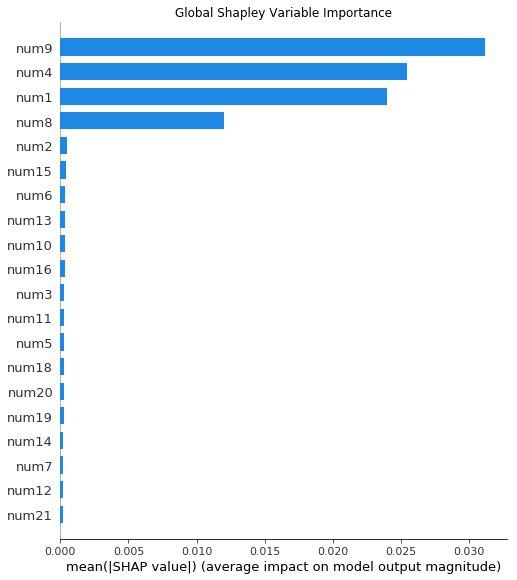

In [12]:
#Set all shapley values to their absolute value
shap_values_abs = np.absolute(shap_values[:,:,:-1])

#Plot mean absolute shapley across all classes for global shapley variable importance
# plt.title("Global Shapley Variable Importance")
# shap.summary_plot(shap_values_abs.mean(axis=1), test[xgb_model.feature_names], plot_type="bar", show=False)
# plt.savefig('./images/global_shapley.png',bbox_inches='tight')
# plt.close()

#To show in notebook
plt.title("Global Shapley Variable Importance")
shap.summary_plot(shap_values_abs.mean(axis=1), test[xgb_model.feature_names], plot_type="bar")

### Display Shapley variable importance summary per `target` class outcome

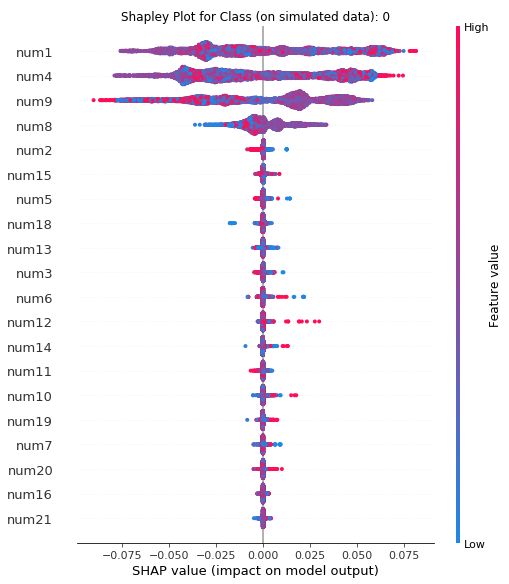

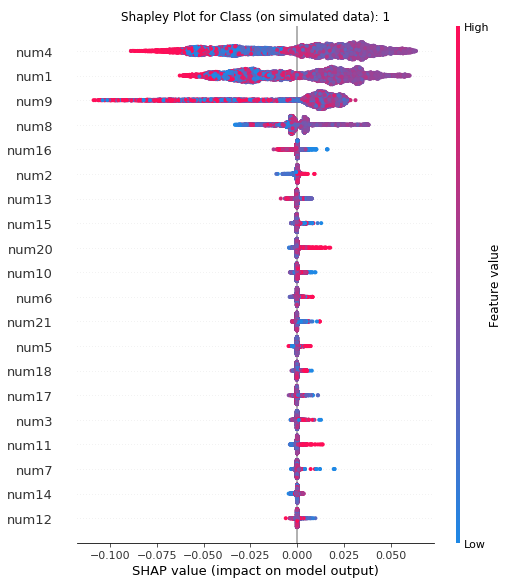

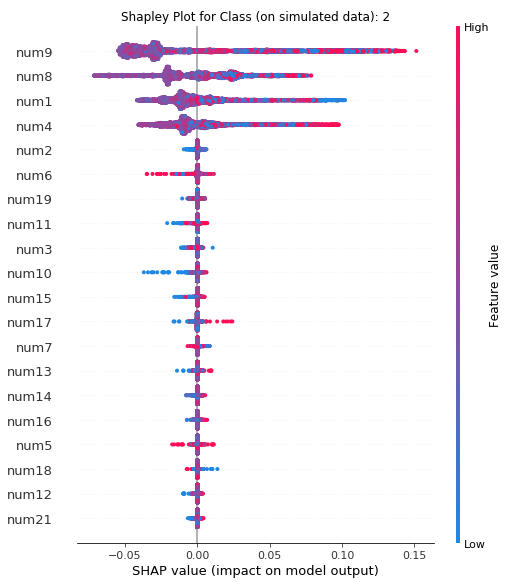

In [13]:
#Plot signed Shapley variable importance summary for a specific class (class 0, class 1, class2)
for i in range(0,3):
    plt.title("Shapley Plot for Class (on simulated data): " + str(i))
    shap.summary_plot(shap_values[:, i, :-1], test[xgb_model.feature_names], show=False)
    plt.savefig('./images/shapley_class_simulated' + str(i) + ".png", bbox_inches='tight')
    plt.close()
    #To show in notebook
    plt.title("Shapley Plot for Class (on simulated data): " + str(i))
    shap.summary_plot(shap_values[:, i, :-1], test[xgb_model.feature_names])

In [14]:
#Predict on test set
preds = xgb_model.predict(dtest)

In [15]:
#Display predictions as a Pandas frame
#Each column represents a class outcome for target: 0, 1, 2
pd.DataFrame(preds).head()

0         1         2
0  0.320520  0.379226  0.300254
1  0.317344  0.383481  0.299175
2  0.357945  0.338415  0.303639
3  0.318002  0.322698  0.359300
4  0.309554  0.350924  0.339522

### 2. Surrogate Decision Trees
#### 2.1 Pre-pruning

In [16]:
from skater.core.visualizer.tree_visualizer import plot_tree, tree_to_text
from skater.util.dataops import show_in_notebook

In [17]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.util.logger import _INFO, _DEBUG

interpreter = Interpretation(X_train_df, feature_names=feature_names)
model_inst = InMemoryModel(gbm.predict, examples=X_train_df, model_type='classifier', 
                           unique_values=[0, 1, 2], probability=False,
                           feature_names=feature_names, target_names=target_names, log_level=_INFO)

In [18]:
# 1. Learner is trained on the decisions of the base model when use_oracle=True; when 'False' original labels are used
# to learn a more interpretable tree based model.

# 2. Learner uses F1 metric as the default metric of choice for classification.
# 3. set verbose=True for more detailed information
surrogate_explainer = interpreter.tree_surrogate(oracle=model_inst, seed=5)
surrogate_explainer.fit(X_train_df, y_train, use_oracle=True, prune='pre', scorer_type='f1')

2018-10-17 03:06:23,155 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2018-10-17 03:06:23,157 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2018-10-17 03:06:38,201 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (20946,)
2018-10-17 03:06:38,215 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.668; oracle score 0.853
2018-10-17 03:06:38,216 - skater.core.global_interpretation.tree_surrogate - WARNING - impurity score: 0.185 of the surrogate model is higher than the impurity threshold: 0.01. The higher the impurity score, lower is the fidelity/faithfulness of the surrogate model


0.185

#### Evaluation on train and test using the Surrogate Tree(pre-pruning)

In [19]:
y_hat_train_s_pre = surrogate_explainer.predict(X_train_df)
y_hat_s_pre = surrogate_explainer.predict(X_test_df)

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_train, y_hat_train_s_pre, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_hat_s_pre, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.69      0.57      0.63      7055
    class 1       0.71      0.45      0.55      9489
    class 2       0.42      0.86      0.56      4402

avg / total       0.64      0.58      0.58     20946


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.67      0.57      0.61      2976
    class 1       0.69      0.44      0.54      4132
    class 2       0.42      0.84      0.56      1946

avg / total       0.63      0.57      0.57      9054



##### Conclusing using the Surrogate Tree with pre-pruning
From initial evaluation, it seems the performance of the model has reduced when using the simplified surrogate tree for evaluating the test dataset.

In [20]:
# Only the leaf notes(containing the respective class labels) are colored
surrogate_explainer.plot_global_decisions(colors=['coral', 'darkturquoise', 'darkseagreen'], 
                                          file_name='simple_tree_prepruned_simulated.png')

2018-10-17 03:06:38,818 - skater.util.dataops - INFO - File Name: simple_tree_prepruned_simulated.png


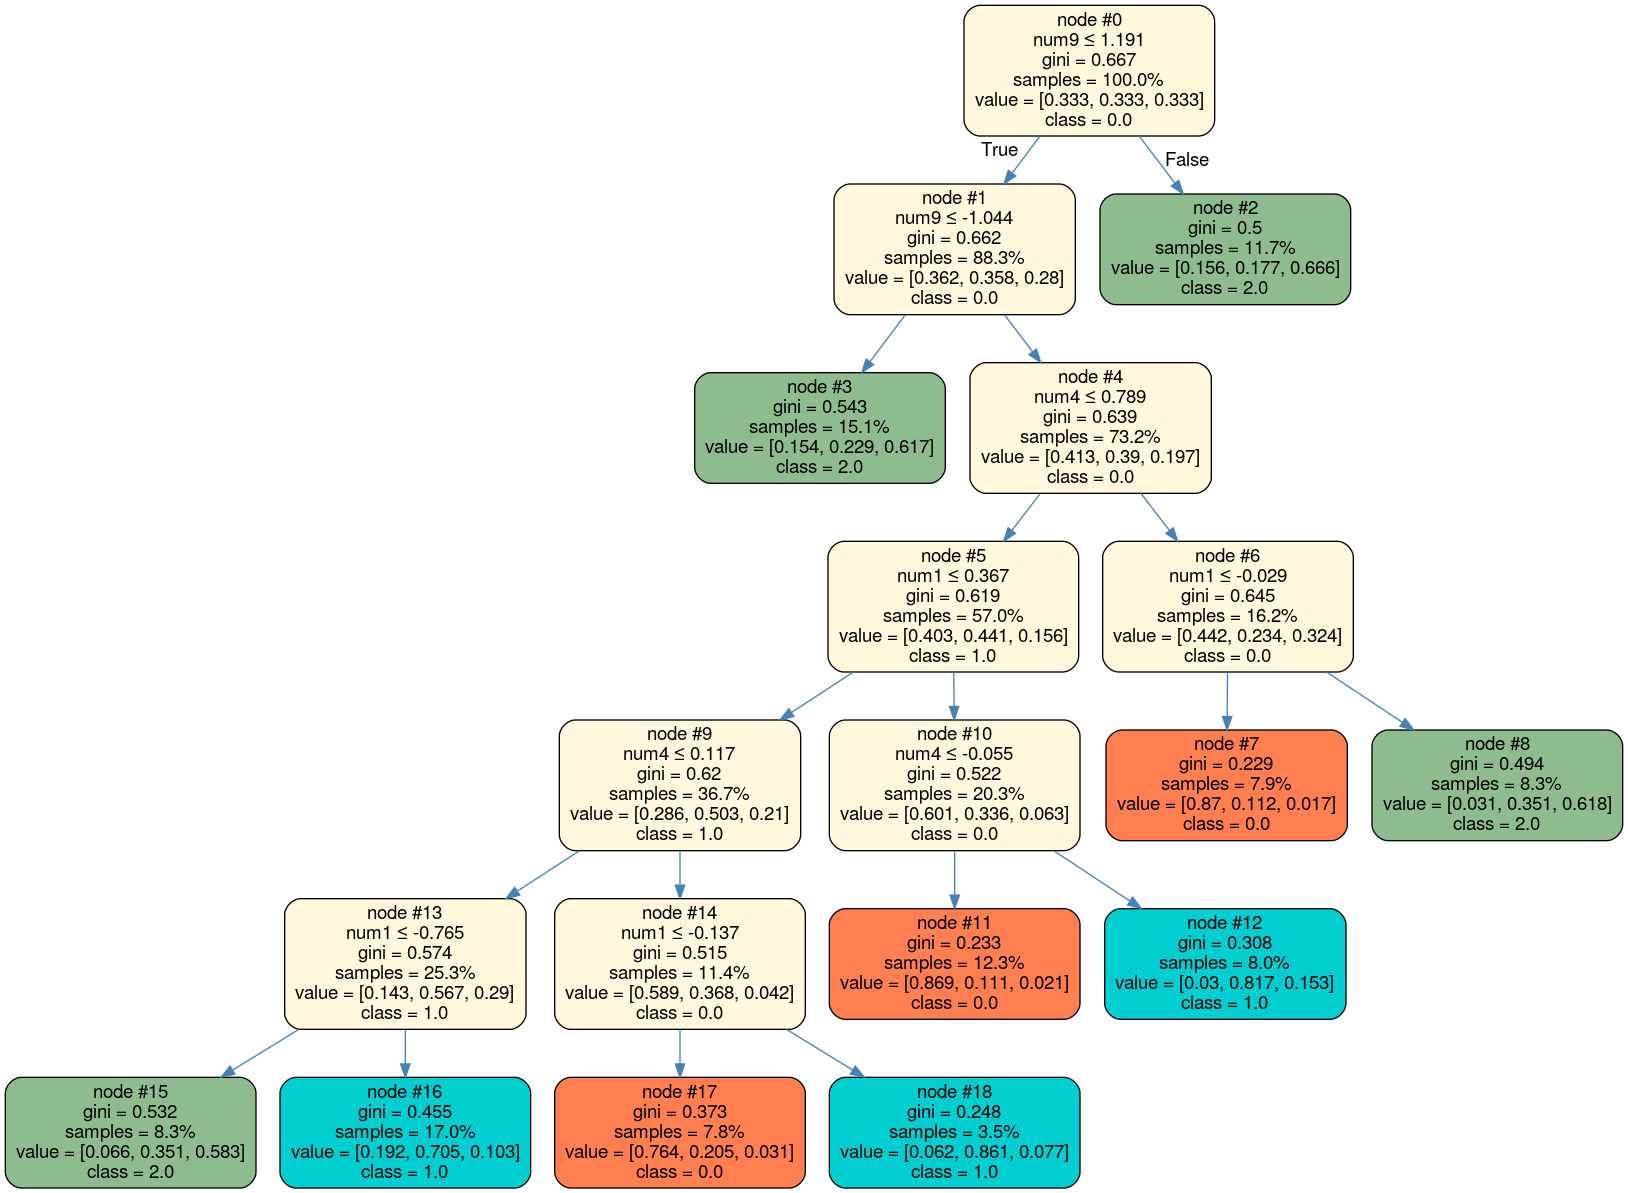

In [21]:
# Thing to notice here would be the fact that the node includes the top ranking features in the pre-pruned tree
# namely (num1, num4, num9)
%matplotlib inline
show_in_notebook('simple_tree_prepruned_simulated.png', width=600, height=500)

#### 2.2 Post pruning

In [22]:
surrogate_explainer2 = interpreter.tree_surrogate(oracle=model_inst, seed=5)
# One can control the impurity threshold parameter while constructing the tree. That may help in controling the size
# in-case the post-pruned tree is very big.
surrogate_explainer2.fit(X_train_df, y_train, use_oracle=True, prune='post', verbose=True, impurity_threshold=0.001)

2018-10-17 03:08:25,582 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2018-10-17 03:08:26,434 - skater.core.global_interpretation.tree_surrogate - DEBUG - Unique Labels in ground truth provided [0. 1. 2.]
2018-10-17 03:08:26,436 - skater.core.global_interpretation.tree_surrogate - DEBUG - Unique Labels in predictions generated [0. 1. 2.]
2018-10-17 03:08:26,438 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2018-10-17 03:08:26,445 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 1.0
2018-10-17 03:08:26,453 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.1330138775326799
2018-10-17 03:08:26,455 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 0 back
2018-10-17 03:08:26,464 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.30826810294871165
2018-10-17 03:08:26,465 - skater.core.global_

2018-10-17 03:08:26,898 - skater.core.global_interpretation.tree_surrogate - DEBUG - Removed nodes: (index:49-->[left node: 50, right node: 51])
2018-10-17 03:08:26,910 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9986167384972546
2018-10-17 03:08:26,912 - skater.core.global_interpretation.tree_surrogate - DEBUG - Removed nodes: (index:51-->[left node: 52, right node: 55])
2018-10-17 03:08:26,925 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9986167384972546
2018-10-17 03:08:26,927 - skater.core.global_interpretation.tree_surrogate - DEBUG - Removed nodes: (index:52-->[left node: 53, right node: 54])
2018-10-17 03:08:26,939 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734732627487
2018-10-17 03:08:26,941 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 56 back
2018-10-17 03:08:26,953 - skater.core.global_interpretation.tree_surrogate - DEBUG - new sc

2018-10-17 03:08:27,424 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 119 back
2018-10-17 03:08:27,435 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:27,437 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 122 back
2018-10-17 03:08:27,448 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:27,450 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 125 back
2018-10-17 03:08:27,461 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983306696337043
2018-10-17 03:08:27,463 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 129 back
2018-10-17 03:08:27,474 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.997806897773908
2018-10-17 03:08:27,476 - skater.core.global_interpretation.tree_surrogate - DEBUG - 

2018-10-17 03:08:27,889 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983306495607533
2018-10-17 03:08:27,890 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 193 back
2018-10-17 03:08:27,902 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984259067179817
2018-10-17 03:08:27,904 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 194 back
2018-10-17 03:08:27,915 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:27,917 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 196 back
2018-10-17 03:08:27,928 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984259315704802
2018-10-17 03:08:27,930 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 199 back
2018-10-17 03:08:27,941 - skater.core.global_interpretation.tree_surrogate - DEBUG -

2018-10-17 03:08:28,344 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 268 back
2018-10-17 03:08:28,355 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9932669570949739
2018-10-17 03:08:28,357 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 269 back
2018-10-17 03:08:28,368 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9962855293387143
2018-10-17 03:08:28,370 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 270 back
2018-10-17 03:08:28,381 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9977592395309441
2018-10-17 03:08:28,382 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 271 back
2018-10-17 03:08:28,394 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984257120031543
2018-10-17 03:08:28,395 - skater.core.global_interpretation.tree_surrogate - DEBUG -

2018-10-17 03:08:28,826 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982824213172713
2018-10-17 03:08:28,828 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 338 back
2018-10-17 03:08:28,839 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982354178793685
2018-10-17 03:08:28,840 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 339 back
2018-10-17 03:08:28,851 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:28,853 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 340 back
2018-10-17 03:08:28,864 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984256583652564
2018-10-17 03:08:28,866 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 344 back
2018-10-17 03:08:28,877 - skater.core.global_interpretation.tree_surrogate - DEBUG -

2018-10-17 03:08:29,301 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 410 back
2018-10-17 03:08:29,313 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9890617149509803
2018-10-17 03:08:29,315 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 411 back
2018-10-17 03:08:29,327 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9979973329420311
2018-10-17 03:08:29,330 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 412 back
2018-10-17 03:08:29,341 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9980925593067106
2018-10-17 03:08:29,344 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 413 back
2018-10-17 03:08:29,356 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983306696337043
2018-10-17 03:08:29,358 - skater.core.global_interpretation.tree_surrogate - DEBUG -

2018-10-17 03:08:29,798 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984256749093429
2018-10-17 03:08:29,800 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 480 back
2018-10-17 03:08:29,811 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983299752609845
2018-10-17 03:08:29,813 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 483 back
2018-10-17 03:08:29,824 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:29,826 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 485 back
2018-10-17 03:08:29,837 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9921208061130368
2018-10-17 03:08:29,839 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 488 back
2018-10-17 03:08:29,850 - skater.core.global_interpretation.tree_surrogate - DEBUG -

2018-10-17 03:08:30,294 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 545 back
2018-10-17 03:08:30,306 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983777846488056
2018-10-17 03:08:30,308 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 546 back
2018-10-17 03:08:30,319 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:30,321 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 548 back
2018-10-17 03:08:30,333 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:30,335 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 552 back
2018-10-17 03:08:30,347 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982345059689336
2018-10-17 03:08:30,349 - skater.core.global_interpretation.tree_surrogate - DEBUG -

2018-10-17 03:08:30,819 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9976641408865158
2018-10-17 03:08:30,821 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 623 back
2018-10-17 03:08:30,833 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:30,835 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 624 back
2018-10-17 03:08:30,847 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982830248020412
2018-10-17 03:08:30,849 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 627 back
2018-10-17 03:08:30,861 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735391202983
2018-10-17 03:08:30,864 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 629 back
2018-10-17 03:08:30,876 - skater.core.global_interpretation.tree_surrogate - DEBUG -

2018-10-17 03:08:31,331 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 695 back
2018-10-17 03:08:31,342 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9956685011387061
2018-10-17 03:08:31,344 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 696 back
2018-10-17 03:08:31,356 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9957633874196025
2018-10-17 03:08:31,359 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 698 back
2018-10-17 03:08:31,370 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9958108471207441
2018-10-17 03:08:31,372 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 700 back
2018-10-17 03:08:31,390 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9962380749809683
2018-10-17 03:08:31,393 - skater.core.global_interpretation.tree_surrogate - DEBUG -

2018-10-17 03:08:31,855 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:31,857 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 761 back
2018-10-17 03:08:31,869 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983306231967598
2018-10-17 03:08:31,871 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 766 back
2018-10-17 03:08:31,882 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983782481118456
2018-10-17 03:08:31,885 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 768 back
2018-10-17 03:08:31,896 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984258755751576
2018-10-17 03:08:31,898 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 770 back
2018-10-17 03:08:31,910 - skater.core.global_interpretation.tree_surrogate - DEBUG -

2018-10-17 03:08:32,326 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 833 back
2018-10-17 03:08:32,337 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984259067179817
2018-10-17 03:08:32,339 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 836 back
2018-10-17 03:08:32,350 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:32,352 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 838 back
2018-10-17 03:08:32,363 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9933464522137797
2018-10-17 03:08:32,365 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 842 back
2018-10-17 03:08:32,376 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9971408501383799
2018-10-17 03:08:32,378 - skater.core.global_interpretation.tree_surrogate - DEBUG -

2018-10-17 03:08:32,791 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983782993283374
2018-10-17 03:08:32,793 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 905 back
2018-10-17 03:08:32,804 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984259315704802
2018-10-17 03:08:32,806 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 906 back
2018-10-17 03:08:32,817 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:32,819 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 907 back
2018-10-17 03:08:32,830 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983302166150909
2018-10-17 03:08:32,832 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 914 back
2018-10-17 03:08:32,843 - skater.core.global_interpretation.tree_surrogate - DEBUG -

2018-10-17 03:08:33,248 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 978 back
2018-10-17 03:08:33,259 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9972360008760212
2018-10-17 03:08:33,260 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 982 back
2018-10-17 03:08:33,271 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984256583652564
2018-10-17 03:08:33,273 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 983 back
2018-10-17 03:08:33,284 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735391202983
2018-10-17 03:08:33,286 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 984 back
2018-10-17 03:08:33,297 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.997426250976152
2018-10-17 03:08:33,299 - skater.core.global_interpretation.tree_surrogate - DEBUG - 

2018-10-17 03:08:33,709 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9973310496434186
2018-10-17 03:08:33,711 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1044 back
2018-10-17 03:08:33,723 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984258755751576
2018-10-17 03:08:33,725 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1045 back
2018-10-17 03:08:33,736 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9974262138002055
2018-10-17 03:08:33,738 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1048 back
2018-10-17 03:08:33,750 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735391202983
2018-10-17 03:08:33,751 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1049 back
2018-10-17 03:08:33,763 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:34,175 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1114 back
2018-10-17 03:08:34,186 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9976641203344946
2018-10-17 03:08:34,188 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1119 back
2018-10-17 03:08:34,199 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9980925593067106
2018-10-17 03:08:34,201 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1120 back
2018-10-17 03:08:34,212 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983306696337043
2018-10-17 03:08:34,214 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1122 back
2018-10-17 03:08:34,225 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984259315704802
2018-10-17 03:08:34,227 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:34,642 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982345696747301
2018-10-17 03:08:34,644 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1188 back
2018-10-17 03:08:34,655 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984257417351845
2018-10-17 03:08:34,657 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1189 back
2018-10-17 03:08:34,668 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734608157603
2018-10-17 03:08:34,670 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1192 back
2018-10-17 03:08:34,681 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983782993283374
2018-10-17 03:08:34,683 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1195 back
2018-10-17 03:08:34,694 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:35,102 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1257 back
2018-10-17 03:08:35,113 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9981401489806929
2018-10-17 03:08:35,115 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1259 back
2018-10-17 03:08:35,127 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9981877829149254
2018-10-17 03:08:35,128 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1260 back
2018-10-17 03:08:35,140 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982354025873982
2018-10-17 03:08:35,142 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1262 back
2018-10-17 03:08:35,153 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982830248020412
2018-10-17 03:08:35,155 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:35,568 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9966121156147073
2018-10-17 03:08:35,570 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1332 back
2018-10-17 03:08:35,581 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983779672727685
2018-10-17 03:08:35,583 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1333 back
2018-10-17 03:08:35,594 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:35,596 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1334 back
2018-10-17 03:08:35,607 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9977093990350309
2018-10-17 03:08:35,609 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1338 back
2018-10-17 03:08:35,620 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:36,045 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1400 back
2018-10-17 03:08:36,056 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982830248020412
2018-10-17 03:08:36,058 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1401 back
2018-10-17 03:08:36,069 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:36,071 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1402 back
2018-10-17 03:08:36,082 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:36,084 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1405 back
2018-10-17 03:08:36,095 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9976607315262921
2018-10-17 03:08:36,097 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:36,510 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983779127570963
2018-10-17 03:08:36,512 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1470 back
2018-10-17 03:08:36,524 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983777846488056
2018-10-17 03:08:36,526 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1473 back
2018-10-17 03:08:36,539 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.998425592517857
2018-10-17 03:08:36,541 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1474 back
2018-10-17 03:08:36,554 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.998425592517857
2018-10-17 03:08:36,557 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1476 back
2018-10-17 03:08:36,570 - skater.core.global_interpretation.tree_surrogate - DEBUG

2018-10-17 03:08:37,056 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1544 back
2018-10-17 03:08:37,068 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982830008280007
2018-10-17 03:08:37,070 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1546 back
2018-10-17 03:08:37,082 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984258755751576
2018-10-17 03:08:37,084 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1547 back
2018-10-17 03:08:37,096 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735391202983
2018-10-17 03:08:37,098 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1548 back
2018-10-17 03:08:37,110 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9975180948917695
2018-10-17 03:08:37,112 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:37,589 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9959916844499864
2018-10-17 03:08:37,591 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1616 back
2018-10-17 03:08:37,603 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9974707144774003
2018-10-17 03:08:37,605 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1617 back
2018-10-17 03:08:37,617 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9979958692592675
2018-10-17 03:08:37,619 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1618 back
2018-10-17 03:08:37,631 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983779127570963
2018-10-17 03:08:37,633 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1620 back
2018-10-17 03:08:37,644 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:38,090 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1685 back
2018-10-17 03:08:38,102 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984256749093429
2018-10-17 03:08:38,103 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1686 back
2018-10-17 03:08:38,116 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:38,118 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1687 back
2018-10-17 03:08:38,130 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.998425592517857
2018-10-17 03:08:38,132 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1691 back
2018-10-17 03:08:38,144 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9969920198389408
2018-10-17 03:08:38,146 - skater.core.global_interpretation.tree_surrogate - DEBU

2018-10-17 03:08:38,613 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9976139207901336
2018-10-17 03:08:38,615 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1757 back
2018-10-17 03:08:38,627 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9979958692592675
2018-10-17 03:08:38,629 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1759 back
2018-10-17 03:08:38,641 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9981391243988623
2018-10-17 03:08:38,643 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1761 back
2018-10-17 03:08:38,654 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982823929371254
2018-10-17 03:08:38,657 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1763 back
2018-10-17 03:08:38,669 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:39,121 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1825 back
2018-10-17 03:08:39,133 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:39,135 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1826 back
2018-10-17 03:08:39,147 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983299752609845
2018-10-17 03:08:39,149 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1829 back
2018-10-17 03:08:39,162 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.998425592517857
2018-10-17 03:08:39,164 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1830 back
2018-10-17 03:08:39,176 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9967548807241986
2018-10-17 03:08:39,179 - skater.core.global_interpretation.tree_surrogate - DEBU

2018-10-17 03:08:39,693 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.998425592517857
2018-10-17 03:08:39,695 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1898 back
2018-10-17 03:08:39,707 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:39,709 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1900 back
2018-10-17 03:08:39,721 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9973752509567778
2018-10-17 03:08:39,723 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1903 back
2018-10-17 03:08:39,735 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9980913711986653
2018-10-17 03:08:39,737 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1904 back
2018-10-17 03:08:39,749 - skater.core.global_interpretation.tree_surrogate - DEBU

2018-10-17 03:08:40,209 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1968 back
2018-10-17 03:08:40,222 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982823929371254
2018-10-17 03:08:40,224 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1972 back
2018-10-17 03:08:40,237 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982823929371254
2018-10-17 03:08:40,240 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1973 back
2018-10-17 03:08:40,252 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984256749093429
2018-10-17 03:08:40,254 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1974 back
2018-10-17 03:08:40,267 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:40,270 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:40,778 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9967035430274237
2018-10-17 03:08:40,780 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2043 back
2018-10-17 03:08:40,793 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9979474453252594
2018-10-17 03:08:40,794 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2044 back
2018-10-17 03:08:40,807 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9981387224957681
2018-10-17 03:08:40,809 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2045 back
2018-10-17 03:08:40,822 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:40,824 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2046 back
2018-10-17 03:08:40,837 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:41,300 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2113 back
2018-10-17 03:08:41,322 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.997134243124399
2018-10-17 03:08:41,324 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2114 back
2018-10-17 03:08:41,337 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.998425592517857
2018-10-17 03:08:41,339 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2115 back
2018-10-17 03:08:41,352 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:41,354 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2116 back
2018-10-17 03:08:41,367 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9977571403723141
2018-10-17 03:08:41,369 - skater.core.global_interpretation.tree_surrogate - DEBUG

2018-10-17 03:08:41,856 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:41,858 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2181 back
2018-10-17 03:08:41,871 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:41,873 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2182 back
2018-10-17 03:08:41,886 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983779127570963
2018-10-17 03:08:41,887 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2186 back
2018-10-17 03:08:41,900 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:41,902 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2189 back
2018-10-17 03:08:41,914 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:42,389 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2251 back
2018-10-17 03:08:42,401 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982823929371254
2018-10-17 03:08:42,403 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2254 back
2018-10-17 03:08:42,416 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983779127570963
2018-10-17 03:08:42,418 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2256 back
2018-10-17 03:08:42,431 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984256749093429
2018-10-17 03:08:42,433 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2257 back
2018-10-17 03:08:42,446 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:42,448 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:42,933 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983301521001263
2018-10-17 03:08:42,934 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2321 back
2018-10-17 03:08:42,947 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982823929371254
2018-10-17 03:08:42,949 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2325 back
2018-10-17 03:08:42,961 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983779127570963
2018-10-17 03:08:42,963 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2326 back
2018-10-17 03:08:42,976 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:42,978 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2327 back
2018-10-17 03:08:42,990 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:43,459 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2396 back
2018-10-17 03:08:43,472 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984256749093429
2018-10-17 03:08:43,474 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2398 back
2018-10-17 03:08:43,487 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:43,488 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2399 back
2018-10-17 03:08:43,501 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:43,503 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2400 back
2018-10-17 03:08:43,516 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:43,518 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:43,993 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:43,995 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2466 back
2018-10-17 03:08:44,008 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:44,010 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2469 back
2018-10-17 03:08:44,023 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:44,025 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2471 back
2018-10-17 03:08:44,038 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984256749093429
2018-10-17 03:08:44,040 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2474 back
2018-10-17 03:08:44,052 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:44,519 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2539 back
2018-10-17 03:08:44,537 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:44,539 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2540 back
2018-10-17 03:08:44,552 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983779127570963
2018-10-17 03:08:44,554 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2543 back
2018-10-17 03:08:44,566 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9977571403723141
2018-10-17 03:08:44,568 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2546 back
2018-10-17 03:08:44,581 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9979481205174549
2018-10-17 03:08:44,583 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:45,058 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983299752609845
2018-10-17 03:08:45,060 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2611 back
2018-10-17 03:08:45,072 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:45,074 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2612 back
2018-10-17 03:08:45,087 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9981868760175303
2018-10-17 03:08:45,089 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2616 back
2018-10-17 03:08:45,102 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982346245018757
2018-10-17 03:08:45,103 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2617 back
2018-10-17 03:08:45,116 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:45,587 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2679 back
2018-10-17 03:08:45,600 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:45,602 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2680 back
2018-10-17 03:08:45,615 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:45,617 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2684 back
2018-10-17 03:08:45,630 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982821643530823
2018-10-17 03:08:45,632 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2687 back
2018-10-17 03:08:45,645 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9981868790878003
2018-10-17 03:08:45,647 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:46,123 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982830248020412
2018-10-17 03:08:46,125 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2756 back
2018-10-17 03:08:46,137 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:46,139 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2758 back
2018-10-17 03:08:46,152 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9063265718110626
2018-10-17 03:08:46,154 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2761 back
2018-10-17 03:08:46,166 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9841256306888587
2018-10-17 03:08:46,168 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2762 back
2018-10-17 03:08:46,181 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:46,641 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2822 back
2018-10-17 03:08:46,654 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:46,656 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2823 back
2018-10-17 03:08:46,668 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:46,670 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2827 back
2018-10-17 03:08:46,683 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983778543982483
2018-10-17 03:08:46,685 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2830 back
2018-10-17 03:08:46,698 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.998425592517857
2018-10-17 03:08:46,699 - skater.core.global_interpretation.tree_surrogate - DEBU

2018-10-17 03:08:47,171 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:47,173 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2891 back
2018-10-17 03:08:47,186 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:47,188 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2892 back
2018-10-17 03:08:47,201 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984256749093429
2018-10-17 03:08:47,203 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2896 back
2018-10-17 03:08:47,215 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983779127570963
2018-10-17 03:08:47,217 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2899 back
2018-10-17 03:08:47,230 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:47,705 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2965 back
2018-10-17 03:08:47,717 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982353531275847
2018-10-17 03:08:47,719 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2966 back
2018-10-17 03:08:47,732 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984259067179817
2018-10-17 03:08:47,734 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2967 back
2018-10-17 03:08:47,750 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:47,751 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2969 back
2018-10-17 03:08:47,764 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984256749093429
2018-10-17 03:08:47,766 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:48,235 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:48,237 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3039 back
2018-10-17 03:08:48,252 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:48,254 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3042 back
2018-10-17 03:08:48,266 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9533575650278133
2018-10-17 03:08:48,268 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3045 back
2018-10-17 03:08:48,280 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9953199799176582
2018-10-17 03:08:48,282 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3046 back
2018-10-17 03:08:48,295 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:48,763 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3107 back
2018-10-17 03:08:48,775 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982824372007951
2018-10-17 03:08:48,777 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3110 back
2018-10-17 03:08:48,790 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734732627487
2018-10-17 03:08:48,791 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3112 back
2018-10-17 03:08:48,804 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.998425592517857
2018-10-17 03:08:48,806 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3115 back
2018-10-17 03:08:48,819 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:48,821 - skater.core.global_interpretation.tree_surrogate - DEBU

2018-10-17 03:08:49,322 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984259315704802
2018-10-17 03:08:49,324 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3178 back
2018-10-17 03:08:49,336 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:49,338 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3181 back
2018-10-17 03:08:49,350 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982830424846812
2018-10-17 03:08:49,352 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3184 back
2018-10-17 03:08:49,365 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983306696337043
2018-10-17 03:08:49,367 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3185 back
2018-10-17 03:08:49,384 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:49,845 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3251 back
2018-10-17 03:08:49,858 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:49,859 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3252 back
2018-10-17 03:08:49,872 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:49,874 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3254 back
2018-10-17 03:08:49,887 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982830008280007
2018-10-17 03:08:49,888 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3257 back
2018-10-17 03:08:49,901 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984258755751576
2018-10-17 03:08:49,903 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:50,397 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9976165571931133
2018-10-17 03:08:50,399 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3319 back
2018-10-17 03:08:50,412 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983782768654336
2018-10-17 03:08:50,414 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3320 back
2018-10-17 03:08:50,427 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:50,429 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3321 back
2018-10-17 03:08:50,442 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9977593222864539
2018-10-17 03:08:50,443 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3325 back
2018-10-17 03:08:50,457 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:50,942 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3385 back
2018-10-17 03:08:50,955 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983782768654336
2018-10-17 03:08:50,958 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3388 back
2018-10-17 03:08:50,973 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735391202983
2018-10-17 03:08:50,975 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3389 back
2018-10-17 03:08:50,988 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735391202983
2018-10-17 03:08:50,990 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3390 back
2018-10-17 03:08:51,003 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984259315704802
2018-10-17 03:08:51,005 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:51,491 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9981877382360924
2018-10-17 03:08:51,493 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3462 back
2018-10-17 03:08:51,505 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:51,507 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3463 back
2018-10-17 03:08:51,520 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982830008280007
2018-10-17 03:08:51,522 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3466 back
2018-10-17 03:08:51,542 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983782768654336
2018-10-17 03:08:51,544 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3467 back
2018-10-17 03:08:51,557 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:52,018 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3528 back
2018-10-17 03:08:52,031 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:52,033 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3529 back
2018-10-17 03:08:52,046 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734608157603
2018-10-17 03:08:52,048 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3532 back
2018-10-17 03:08:52,061 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:52,063 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3535 back
2018-10-17 03:08:52,076 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9980448532908365
2018-10-17 03:08:52,078 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:52,556 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9980925511888997
2018-10-17 03:08:52,558 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3600 back
2018-10-17 03:08:52,571 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:52,572 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3601 back
2018-10-17 03:08:52,585 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.998140165782725
2018-10-17 03:08:52,587 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3604 back
2018-10-17 03:08:52,600 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:52,602 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3605 back
2018-10-17 03:08:52,614 - skater.core.global_interpretation.tree_surrogate - DEBU

2018-10-17 03:08:53,078 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3676 back
2018-10-17 03:08:53,091 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734608157603
2018-10-17 03:08:53,093 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3678 back
2018-10-17 03:08:53,105 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9960480364041264
2018-10-17 03:08:53,107 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3681 back
2018-10-17 03:08:53,122 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9961905293206325
2018-10-17 03:08:53,124 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3683 back
2018-10-17 03:08:53,137 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9963330307772948
2018-10-17 03:08:53,139 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:53,609 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9878165307912725
2018-10-17 03:08:53,611 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3749 back
2018-10-17 03:08:53,624 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9941371041322692
2018-10-17 03:08:53,626 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3750 back
2018-10-17 03:08:53,639 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9954310435196974
2018-10-17 03:08:53,641 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3751 back
2018-10-17 03:08:53,654 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9979020847496881
2018-10-17 03:08:53,656 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3752 back
2018-10-17 03:08:53,669 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:54,131 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3815 back
2018-10-17 03:08:54,145 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734608157603
2018-10-17 03:08:54,147 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3816 back
2018-10-17 03:08:54,159 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.998425592517857
2018-10-17 03:08:54,161 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3820 back
2018-10-17 03:08:54,174 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735391202983
2018-10-17 03:08:54,176 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3823 back
2018-10-17 03:08:54,190 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9978997310318622
2018-10-17 03:08:54,192 - skater.core.global_interpretation.tree_surrogate - DEBU

2018-10-17 03:08:54,676 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:54,678 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3889 back
2018-10-17 03:08:54,691 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:54,694 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3892 back
2018-10-17 03:08:54,706 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9979483518812695
2018-10-17 03:08:54,708 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3895 back
2018-10-17 03:08:54,721 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9980914714913727
2018-10-17 03:08:54,723 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3896 back
2018-10-17 03:08:54,735 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:55,202 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3958 back
2018-10-17 03:08:55,215 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982824372007951
2018-10-17 03:08:55,216 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3959 back
2018-10-17 03:08:55,229 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983301521001263
2018-10-17 03:08:55,231 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3961 back
2018-10-17 03:08:55,255 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983779127570963
2018-10-17 03:08:55,257 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3962 back
2018-10-17 03:08:55,271 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:55,273 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:55,751 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983778543982483
2018-10-17 03:08:55,753 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4034 back
2018-10-17 03:08:55,765 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984257120031543
2018-10-17 03:08:55,768 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4036 back
2018-10-17 03:08:55,781 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:55,782 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4037 back
2018-10-17 03:08:55,798 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.991553391998964
2018-10-17 03:08:55,800 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4041 back
2018-10-17 03:08:55,813 - skater.core.global_interpretation.tree_surrogate - DEBU

2018-10-17 03:08:56,298 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4104 back
2018-10-17 03:08:56,311 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9979972818453587
2018-10-17 03:08:56,313 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4105 back
2018-10-17 03:08:56,326 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9981877064570108
2018-10-17 03:08:56,337 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4106 back
2018-10-17 03:08:56,350 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983306495607533
2018-10-17 03:08:56,352 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4107 back
2018-10-17 03:08:56,366 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:56,368 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:56,881 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:56,883 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4171 back
2018-10-17 03:08:56,896 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984259315704802
2018-10-17 03:08:56,898 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4174 back
2018-10-17 03:08:56,911 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:56,913 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4175 back
2018-10-17 03:08:56,926 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984735663620331
2018-10-17 03:08:56,932 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4178 back
2018-10-17 03:08:56,945 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:57,405 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4242 back
2018-10-17 03:08:57,418 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984733988694504
2018-10-17 03:08:57,420 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4243 back
2018-10-17 03:08:57,433 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983782993283374
2018-10-17 03:08:57,435 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4246 back
2018-10-17 03:08:57,447 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9982830424846812
2018-10-17 03:08:57,449 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4250 back
2018-10-17 03:08:57,462 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983782993283374
2018-10-17 03:08:57,464 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:57,924 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9969505418950573
2018-10-17 03:08:57,926 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4319 back
2018-10-17 03:08:57,938 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983305905411286
2018-10-17 03:08:57,940 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4320 back
2018-10-17 03:08:57,952 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:57,954 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4322 back
2018-10-17 03:08:57,966 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9971407753923155
2018-10-17 03:08:57,968 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4325 back
2018-10-17 03:08:57,979 - skater.core.global_interpretation.tree_surrogate - DEB

2018-10-17 03:08:58,412 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4389 back
2018-10-17 03:08:58,423 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9983777846488056
2018-10-17 03:08:58,425 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4390 back
2018-10-17 03:08:58,436 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:58,438 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4392 back
2018-10-17 03:08:58,449 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984259067179817
2018-10-17 03:08:58,451 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 4395 back
2018-10-17 03:08:58,463 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9984734385581737
2018-10-17 03:08:58,465 - skater.core.global_interpretation.tree_surrogate - DEB

-0.146

In [26]:
# colors could be set to 'None' for randomly selecting the colors
surrogate_explainer2.plot_global_decisions(colors=['coral', 'darkturquoise', 'darkseagreen'], 
                                          file_name='simple_tree_postpruned_simulated.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.20332 to fit



2018-10-17 03:16:58,265 - skater.util.dataops - INFO - File Name: simple_tree_postpruned_simulated.png


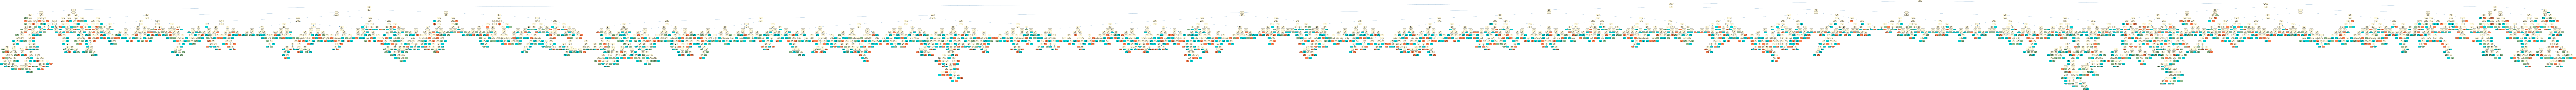

In [27]:
%matplotlib inline
show_in_notebook('simple_tree_postpruned_simulated.png', width=300, height=300)

In [28]:
# Trees could get busy very quickly. In that case, we need alternatives to visualize them in a more convenient way. 
# Text representation may be a convenient choice in that case.
surrogate_explainer2.decisions_as_txt()

if num9 <= 1.1914658546447754 {
  if num9 <= -1.0435385704040527 {
    if num8 <= -0.6968590021133423 {
      if num9 <= -1.181445598602295 {
        if num19 <= 1.8605154752731323 {
          if num2 <= -1.856717586517334 {
            if num1 <= 0.8780747056007385 {
          } else {
            if num17 <= -2.8442296981811523 {
              if num8 <= -1.5368421077728271 {
            } else {
              if num7 <= -2.518427610397339 {
                if num18 <= -0.1823388785123825 {
              } else {
                if num2 <= 1.3680644035339355 {
                  if num9 <= -2.5887975692749023 {
                    if num21 <= 0.1096123456954956 {
                  } else {
                    if num16 <= 2.9983928203582764 {
                      if num12 <= -1.3583447933197021 {
                        if num3 <= -0.8717817068099976 {
                      } else {
                        if num10 <= 1.9155851602554321 {
                          if num13 <= -2.89249

                                              }
                                            }
                                          } else {
                                            if num18 <= 0.22675549983978271 {
                                                Predicted Label: 0
                                            } else {
                                                Predicted Label: 1
                                            }
                                          }
                                        } else {
                                          if num12 <= -0.7303586006164551 {
                                              Predicted Label: 1
                                          } else {
                                              Predicted Label: 0
                                          }
                                        }
                                      }
                                    }
                              

                } else {
                    Predicted Label: 1
                }
              }
            }
          } else {
            if num11 <= -0.5905914306640625 {
                Predicted Label: 0
            } else {
                Predicted Label: 1
            }
          }
        } else {
          if num12 <= -0.23948726058006287 {
            if num4 <= 1.0308640003204346 {
              if num16 <= 0.4173652231693268 {
                if num21 <= 0.22433710098266602 {
                    Predicted Label: 2
                } else {
                  if num2 <= 0.8857831954956055 {
                      Predicted Label: 0
                  } else {
                      Predicted Label: 1
                  }
                }
              } else {
                  Predicted Label: 1
              }
            } else {
                Predicted Label: 0
            }
          } else {
            if num4 <= -0.7549359798431396 {
                Predicted Label:

                          if num15 <= -1.2572120428085327 {
                              Predicted Label: 1
                          } else {
                              Predicted Label: 0
                          }
                        }
                      }
                    }
                  } else {
                    if num1 <= -1.1551034450531006 {
                      if num4 <= 0.31260961294174194 {
                        if num18 <= 0.8591899871826172 {
                            Predicted Label: 1
                        } else {
                            Predicted Label: 2
                        }
                      } else {
                          Predicted Label: 0
                      }
                    } else {
                      if num8 <= -0.3388751149177551 {
                        if num16 <= -0.7397930026054382 {
                          if num20 <= -1.4908617734909058 {
                              Predicted Label: 1
           

                if num1 <= 0.38580644130706787 {
                  if num9 <= -1.521606683731079 {
                    if num16 <= 0.5450080633163452 {
                      if num19 <= 1.131709098815918 {
                        if num11 <= -0.7257874011993408 {
                            Predicted Label: 2
                        } else {
                            Predicted Label: 1
                        }
                      } else {
                          Predicted Label: 0
                      }
                    } else {
                      if num9 <= -1.6543054580688477 {
                          Predicted Label: 1
                      } else {
                          Predicted Label: 2
                      }
                    }
                  } else {
                    if num7 <= 2.256525993347168 {
                      if num1 <= 0.3118981719017029 {
                        if num8 <= -0.6706488132476807 {
                            Predicted Label

                        Predicted Label: 1
                    }
                  }
                }
              } else {
                if num4 <= 0.29961735010147095 {
                  if num8 <= 0.503595232963562 {
                    if num11 <= 1.6275699138641357 {
                      if num1 <= 1.205283284187317 {
                        if num1 <= -2.6523284912109375 {
                            Predicted Label: 2
                        } else {
                          if num2 <= 2.9943432807922363 {
                            if num7 <= 0.9941297769546509 {
                              if num15 <= 2.241462230682373 {
                                if num9 <= -1.1496282815933228 {
                                    Predicted Label: 1
                                } else {
                                  if num4 <= -0.39554399251937866 {
                                    if num20 <= -0.1989036351442337 {
                                        Predicted Labe

                        } else {
                          if num17 <= 1.137497067451477 {
                              Predicted Label: 2
                          } else {
                              Predicted Label: 0
                          }
                        }
                      }
                    } else {
                      if num18 <= -0.6520936489105225 {
                          Predicted Label: 1
                      } else {
                          Predicted Label: 2
                      }
                    }
                  }
                }
              }
            }
          } else {
            if num1 <= -0.12485112249851227 {
              if num1 <= -0.34100016951560974 {
                if num15 <= -1.916933536529541 {
                    Predicted Label: 1
                } else {
                  if num5 <= 2.3672256469726562 {
                    if num11 <= -2.0132572650909424 {
                        Predicted Label: 1
     

                                      if num12 <= -1.427856683731079 {
                                        if num12 <= -1.4477119445800781 {
                                            Predicted Label: 2
                                        } else {
                                            Predicted Label: 1
                                        }
                                      } else {
                                          Predicted Label: 2
                                      }
                                    }
                                  }
                                } else {
                                  if num19 <= -0.702102541923523 {
                                      Predicted Label: 1
                                  } else {
                                      Predicted Label: 2
                                  }
                                }
                              } else {
                                if num20 <

                if num4 <= 0.6630326509475708 {
                  if num9 <= -1.1740586757659912 {
                    if num6 <= -0.6949676871299744 {
                      if num2 <= 0.08108238875865936 {
                          Predicted Label: 1
                      } else {
                          Predicted Label: 2
                      }
                    } else {
                      if num12 <= 1.158057689666748 {
                          Predicted Label: 1
                      } else {
                          Predicted Label: 0
                      }
                    }
                  } else {
                    if num10 <= 1.2467625141143799 {
                        Predicted Label: 2
                    } else {
                      if num11 <= 0.2600351870059967 {
                          Predicted Label: 1
                      } else {
                          Predicted Label: 0
                      }
                    }
                  }
    

                        Predicted Label: 1
                    }
                  } else {
                      Predicted Label: 1
                  }
                } else {
                  if num16 <= 0.4180231988430023 {
                      Predicted Label: 2
                  } else {
                      Predicted Label: 1
                  }
                }
              } else {
                if num16 <= 0.6709206104278564 {
                  if num7 <= -0.9142234921455383 {
                    if num18 <= -1.3111097812652588 {
                        Predicted Label: 0
                    } else {
                        Predicted Label: 1
                    }
                  } else {
                      Predicted Label: 2
                  }
                } else {
                  if num1 <= 1.240309238433838 {
                    if num5 <= -1.6642065048217773 {
                        Predicted Label: 2
                    } else {
                       

                        }
                      } else {
                          Predicted Label: 0
                      }
                    }
                  }
                }
              }
            }
          }
        }
      }
    }
  } else {
    if num4 <= 0.7888323068618774 {
      if num1 <= 0.3669593632221222 {
        if num4 <= 0.11714214086532593 {
          if num1 <= -0.7654424905776978 {
            if num4 <= -0.5903540849685669 {
              if num1 <= -1.1355206966400146 {
                if num4 <= -0.711310863494873 {
                  if num2 <= -2.540327787399292 {
                    if num11 <= 0.23542851209640503 {
                        Predicted Label: 0
                    } else {
                        Predicted Label: 2
                    }
                  } else {
                    if num14 <= 2.6023545265197754 {
                      if num17 <= -2.9958996772766113 {
                          Predicted Label: 1
                 

                          if num14 <= 0.12380396574735641 {
                              Predicted Label: 2
                          } else {
                              Predicted Label: 1
                          }
                        }
                      } else {
                          Predicted Label: 1
                      }
                    } else {
                        Predicted Label: 1
                    }
                  } else {
                    if num20 <= 0.47134292125701904 {
                      if num7 <= -0.7978280782699585 {
                          Predicted Label: 1
                      } else {
                        if num5 <= -1.3276705741882324 {
                            Predicted Label: 1
                        } else {
                          if num8 <= 0.7228487730026245 {
                            if num16 <= 0.7194517850875854 {
                                Predicted Label: 2
                            } else {
   

                                  Predicted Label: 2
                              } else {
                                if num16 <= -0.7632893323898315 {
                                    Predicted Label: 1
                                } else {
                                    Predicted Label: 2
                                }
                              }
                            }
                          }
                        } else {
                          if num11 <= 0.980057418346405 {
                              Predicted Label: 0
                          } else {
                              Predicted Label: 1
                          }
                        }
                      } else {
                        if num19 <= -0.8427449464797974 {
                            Predicted Label: 1
                        } else {
                            Predicted Label: 0
                        }
                      }
                    }
 

                        }
                      } else {
                          Predicted Label: 2
                      }
                    }
                  }
                } else {
                  if num8 <= -1.3820605278015137 {
                    if num17 <= -0.3499404788017273 {
                      if num4 <= -0.17974752187728882 {
                        if num2 <= 0.5588573813438416 {
                            Predicted Label: 1
                        } else {
                          if num16 <= 1.3509784936904907 {
                              Predicted Label: 2
                          } else {
                              Predicted Label: 1
                          }
                        }
                      } else {
                          Predicted Label: 2
                      }
                    } else {
                      if num1 <= -0.7836380004882812 {
                          Predicted Label: 1
                      } else {
    

                      if num3 <= 0.5335794687271118 {
                        if num1 <= -0.674115777015686 {
                          if num21 <= -0.9870481491088867 {
                              Predicted Label: 1
                          } else {
                              Predicted Label: 2
                          }
                        } else {
                          if num3 <= 0.014733836054801941 {
                              Predicted Label: 1
                          } else {
                              Predicted Label: 0
                          }
                        }
                      } else {
                          Predicted Label: 1
                      }
                    } else {
                      if num4 <= 0.014842135831713676 {
                        if num21 <= 1.920118808746338 {
                          if num2 <= -2.2393722534179688 {
                              Predicted Label: 0
                          } else {
     

                              Predicted Label: 1
                          }
                        }
                      }
                    }
                  } else {
                    if num4 <= -0.6122437119483948 {
                      if num9 <= -0.3349406123161316 {
                        if num9 <= -1.0206365585327148 {
                            Predicted Label: 2
                        } else {
                          if num11 <= -1.9118075370788574 {
                              Predicted Label: 0
                          } else {
                              Predicted Label: 1
                          }
                        }
                      } else {
                        if num9 <= 0.20578137040138245 {
                          if num8 <= -1.7664939165115356 {
                              Predicted Label: 1
                          } else {
                            if num5 <= 1.6741222143173218 {
                              if num20 <=

                                      Predicted Label: 1
                                  }
                                } else {
                                  if num11 <= 0.8084087371826172 {
                                    if num17 <= -1.1598753929138184 {
                                        Predicted Label: 1
                                    } else {
                                        Predicted Label: 0
                                    }
                                  } else {
                                    if num16 <= 0.19977736473083496 {
                                        Predicted Label: 1
                                    } else {
                                        Predicted Label: 0
                                    }
                                  }
                                }
                              } else {
                                  Predicted Label: 1
                              }
                    

                                                  Predicted Label: 1
                                              } else {
                                                  Predicted Label: 0
                                              }
                                            }
                                          }
                                        }
                                      }
                                    } else {
                                      if num8 <= -0.7656936645507812 {
                                          Predicted Label: 1
                                      } else {
                                        if num14 <= -1.447109341621399 {
                                          if num11 <= -0.5972766876220703 {
                                              Predicted Label: 0
                                          } else {
                                              Predicted Label: 1
                                 

                          if num15 <= -1.2042866945266724 {
                              Predicted Label: 1
                          } else {
                            if num7 <= -1.3282313346862793 {
                                Predicted Label: 1
                            } else {
                              if num9 <= -0.12780210375785828 {
                                if num6 <= -0.5766517519950867 {
                                    Predicted Label: 0
                                } else {
                                    Predicted Label: 1
                                }
                              } else {
                                if num1 <= 0.12243618071079254 {
                                  if num2 <= 1.5334715843200684 {
                                      Predicted Label: 0
                                  } else {
                                      Predicted Label: 1
                                  }
                              

                                } else {
                                    Predicted Label: 1
                                }
                              }
                            } else {
                                Predicted Label: 1
                            }
                          } else {
                              Predicted Label: 1
                          }
                        }
                      } else {
                        if num9 <= -0.6007509231567383 {
                          if num10 <= 0.6262615323066711 {
                            if num17 <= 1.345776081085205 {
                                Predicted Label: 1
                            } else {
                                Predicted Label: 0
                            }
                          } else {
                              Predicted Label: 0
                          }
                        } else {
                            Predicted Label: 0
              

                      } else {
                        if num9 <= 0.37824615836143494 {
                          if num15 <= 2.4564738273620605 {
                            if num4 <= 0.1509121209383011 {
                                Predicted Label: 1
                            } else {
                              if num9 <= -0.3478430509567261 {
                                if num8 <= 1.5638940334320068 {
                                    Predicted Label: 0
                                } else {
                                    Predicted Label: 1
                                }
                              } else {
                                if num1 <= -0.2001352310180664 {
                                    Predicted Label: 0
                                } else {
                                    Predicted Label: 1
                                }
                              }
                            }
                          } else {
       

                          }
                        } else {
                          if num2 <= 1.0154331922531128 {
                            if num8 <= 0.8924150466918945 {
                              if num9 <= 0.6924657821655273 {
                                if num8 <= 0.24240869283676147 {
                                    Predicted Label: 1
                                } else {
                                    Predicted Label: 0
                                }
                              } else {
                                if num18 <= 1.1635627746582031 {
                                    Predicted Label: 1
                                } else {
                                  if num1 <= -0.23731043934822083 {
                                      Predicted Label: 1
                                  } else {
                                      Predicted Label: 0
                                  }
                                }
              

                  } else {
                    if num16 <= 1.1723346710205078 {
                        Predicted Label: 1
                    } else {
                        Predicted Label: 2
                    }
                  }
                }
              }
            } else {
              if num8 <= 0.9115700721740723 {
                if num8 <= -1.17293119430542 {
                  if num11 <= 0.9542487859725952 {
                    if num9 <= 0.9373983144760132 {
                        Predicted Label: 1
                    } else {
                      if num15 <= -1.52488112449646 {
                          Predicted Label: 1
                      } else {
                        if num14 <= 1.3744579553604126 {
                            Predicted Label: 2
                        } else {
                            Predicted Label: 1
                        }
                      }
                    }
                  } else {
                      Predi

                    } else {
                      if num3 <= 1.3157601356506348 {
                        if num1 <= 0.5303853750228882 {
                          if num5 <= 1.7214326858520508 {
                              Predicted Label: 1
                          } else {
                              Predicted Label: 0
                          }
                        } else {
                          if num18 <= -1.6008929014205933 {
                              Predicted Label: 1
                          } else {
                            if num11 <= 1.8523039817810059 {
                              if num21 <= -1.8060646057128906 {
                                  Predicted Label: 1
                              } else {
                                if num3 <= -1.5874532461166382 {
                                  if num5 <= 0.9233149290084839 {
                                      Predicted Label: 1
                                  } else {
                 

                        if num2 <= -0.5949429273605347 {
                            Predicted Label: 1
                        } else {
                            Predicted Label: 0
                        }
                      } else {
                          Predicted Label: 1
                      }
                    }
                  } else {
                    if num1 <= 1.075695276260376 {
                        Predicted Label: 1
                    } else {
                      if num4 <= -0.2423921525478363 {
                          Predicted Label: 1
                      } else {
                          Predicted Label: 0
                      }
                    }
                  }
                } else {
                  if num8 <= 1.3961974382400513 {
                    if num6 <= 2.3546390533447266 {
                      if num15 <= 2.658222198486328 {
                        if num21 <= 2.305299997329712 {
                          if num7 <= -2

                            Predicted Label: 1
                        } else {
                            Predicted Label: 0
                        }
                      }
                    } else {
                        Predicted Label: 0
                    }
                  }
                }
              }
            }
          } else {
            if num4 <= -0.9147162437438965 {
              if num8 <= -1.746903657913208 {
                  Predicted Label: 1
              } else {
                if num6 <= 1.1661653518676758 {
                  if num7 <= -1.1982475519180298 {
                    if num9 <= 0.9010176658630371 {
                        Predicted Label: 0
                    } else {
                      if num21 <= -0.18375924229621887 {
                          Predicted Label: 1
                      } else {
                        if num7 <= -2.013570547103882 {
                            Predicted Label: 1
                        } else {

                              Predicted Label: 1
                          } else {
                              Predicted Label: 0
                          }
                        }
                      }
                    } else {
                      if num11 <= 1.0876719951629639 {
                        if num21 <= -1.6370470523834229 {
                            Predicted Label: 1
                        } else {
                          if num18 <= -0.6621460914611816 {
                            if num2 <= 1.0632972717285156 {
                                Predicted Label: 0
                            } else {
                              if num11 <= -1.0298693180084229 {
                                  Predicted Label: 0
                              } else {
                                  Predicted Label: 1
                              }
                            }
                          } else {
                            if num8 <= 0.544648289680

                      }
                    } else {
                        Predicted Label: 1
                    }
                  } else {
                    if num6 <= -0.9364224076271057 {
                        Predicted Label: 1
                    } else {
                      if num17 <= -0.7746307253837585 {
                          Predicted Label: 1
                      } else {
                          Predicted Label: 2
                      }
                    }
                  }
                } else {
                  if num17 <= 0.37312379479408264 {
                      Predicted Label: 2
                  } else {
                      Predicted Label: 1
                  }
                }
              }
            }
          } else {
            if num4 <= 0.5932120680809021 {
              if num9 <= 0.7979771494865417 {
                if num1 <= 2.7920336723327637 {
                  if num9 <= -0.7797735929489136 {
                    if nu

                        Predicted Label: 1
                    }
                  }
                } else {
                  if num7 <= -1.1893411874771118 {
                      Predicted Label: 2
                  } else {
                    if num16 <= 1.5414555072784424 {
                        Predicted Label: 1
                    } else {
                        Predicted Label: 0
                    }
                  }
                }
              }
            }
          }
        }
      }
    } else {
      if num1 <= -0.028655994683504105 {
        if num9 <= 0.7641664147377014 {
          if num9 <= -0.6129443049430847 {
            if num1 <= -0.462124228477478 {
              if num8 <= 1.7223691940307617 {
                if num8 <= -1.3866322040557861 {
                  if num12 <= -0.026258310303092003 {
                    if num4 <= 1.7774946689605713 {
                        Predicted Label: 1
                    } else {
                        Predi

                            Predicted Label: 1
                        } else {
                          if num12 <= -2.03476619720459 {
                              Predicted Label: 1
                          } else {
                            if num21 <= -0.817940354347229 {
                              if num2 <= -0.3328515291213989 {
                                if num6 <= 0.7101421356201172 {
                                    Predicted Label: 1
                                } else {
                                    Predicted Label: 0
                                }
                              } else {
                                  Predicted Label: 0
                              }
                            } else {
                                Predicted Label: 0
                            }
                          }
                        }
                      } else {
                        if num3 <= -2.260580062866211 {
                      

                    } else {
                        Predicted Label: 1
                    }
                  } else {
                    if num8 <= 2.353484869003296 {
                        Predicted Label: 1
                    } else {
                        Predicted Label: 0
                    }
                  }
                }
              } else {
                  Predicted Label: 1
              }
            }
          }
        } else {
          if num8 <= 1.4743399620056152 {
            if num8 <= -1.3441652059555054 {
              if num11 <= 0.6829773783683777 {
                if num8 <= -1.5296945571899414 {
                  if num21 <= 0.6872838735580444 {
                    if num15 <= 0.18256476521492004 {
                        Predicted Label: 2
                    } else {
                      if num16 <= -0.017291978001594543 {
                          Predicted Label: 0
                      } else {
                          Predicted Labe

                  Predicted Label: 1
              }
            }
          } else {
            if num9 <= 0.8593268394470215 {
              if num1 <= 0.4323906898498535 {
                if num4 <= 3.2450075149536133 {
                  if num2 <= -2.0755882263183594 {
                    if num12 <= -0.386083722114563 {
                        Predicted Label: 0
                    } else {
                      if num21 <= -1.6318747997283936 {
                          Predicted Label: 2
                      } else {
                          Predicted Label: 1
                      }
                    }
                  } else {
                    if num8 <= -2.3341355323791504 {
                      if num6 <= 0.6804765462875366 {
                          Predicted Label: 2
                      } else {
                          Predicted Label: 1
                      }
                    } else {
                      if num1 <= -0.02758749946951866 {
             

                      } else {
                        if num18 <= 0.4867114722728729 {
                            Predicted Label: 1
                        } else {
                            Predicted Label: 0
                        }
                      }
                    } else {
                      if num19 <= 2.00930118560791 {
                        if num21 <= -1.1489125490188599 {
                          if num10 <= -0.22520744800567627 {
                              Predicted Label: 1
                          } else {
                            if num6 <= -0.775214433670044 {
                                Predicted Label: 1
                            } else {
                                Predicted Label: 2
                            }
                          }
                        } else {
                          if num11 <= -2.547819137573242 {
                            if num18 <= -0.20237977802753448 {
                                Predic

                                      if num16 <= -1.5369817018508911 {
                                        if num14 <= -1.0062599182128906 {
                                            Predicted Label: 1
                                        } else {
                                            Predicted Label: 2
                                        }
                                      } else {
                                          Predicted Label: 2
                                      }
                                    } else {
                                      if num16 <= 0.6401005983352661 {
                                          Predicted Label: 2
                                      } else {
                                          Predicted Label: 1
                                      }
                                    }
                                  }
                                } else {
                                  if num3 <= -0.1

                                                            } else {
                                                                Predicted Label: 1
                                                            }
                                                          }
                                                        }
                                                      }
                                                    }
                                                  }
                                                } else {
                                                  if num17 <= 0.20292529463768005 {
                                                    if num15 <= -1.3806471824645996 {
                                                        Predicted Label: 1
                                                    } else {
                                                        Predicted Label: 2
                                                    }
              

                          Predicted Label: 2
                      } else {
                          Predicted Label: 1
                      }
                    } else {
                        Predicted Label: 0
                    }
                  }
                }
              } else {
                if num18 <= 0.24165542423725128 {
                  if num5 <= 1.5565085411071777 {
                    if num16 <= 1.3019962310791016 {
                      if num20 <= 1.2768036127090454 {
                          Predicted Label: 2
                      } else {
                          Predicted Label: 1
                      }
                    } else {
                        Predicted Label: 1
                    }
                  } else {
                      Predicted Label: 1
                  }
                } else {
                  if num2 <= 0.31704339385032654 {
                      Predicted Label: 1
                  } else {
                    i

                                      } else {
                                          Predicted Label: 1
                                      }
                                    }
                                  } else {
                                    if num5 <= -1.391985297203064 {
                                        Predicted Label: 1
                                    } else {
                                        Predicted Label: 2
                                    }
                                  }
                                } else {
                                  if num21 <= -0.5048657655715942 {
                                    if num13 <= 0.05929752066731453 {
                                        Predicted Label: 2
                                    } else {
                                      if num8 <= -1.1895979642868042 {
                                          Predicted Label: 2
                                      } else {
    

                                                        if num20 <= -1.2529598474502563 {
                                                            Predicted Label: 2
                                                        } else {
                                                            Predicted Label: 1
                                                        }
                                                      } else {
                                                          Predicted Label: 0
                                                      }
                                                    } else {
                                                      if num12 <= -1.8068125247955322 {
                                                        if num8 <= -1.816518783569336 {
                                                            Predicted Label: 1
                                                        } else {
                                                    

                              } else {
                                  Predicted Label: 0
                              }
                            }
                          }
                        } else {
                            Predicted Label: 1
                        }
                      } else {
                          Predicted Label: 0
                      }
                    } else {
                      if num15 <= -0.851493239402771 {
                          Predicted Label: 1
                      } else {
                          Predicted Label: 2
                      }
                    }
                  } else {
                    if num16 <= 1.7713901996612549 {
                      if num1 <= 2.2772672176361084 {
                          Predicted Label: 2
                      } else {
                          Predicted Label: 1
                      }
                    } else {
                        Predicted Label: 1
          

                } else {
                    Predicted Label: 1
                }
              }
            }
          } else {
            if num1 <= 0.35234057903289795 {
              if num4 <= -1.8332889080047607 {
                if num1 <= -0.29088762402534485 {
                    Predicted Label: 2
                } else {
                  if num18 <= -0.05785386264324188 {
                      Predicted Label: 1
                  } else {
                      Predicted Label: 0
                  }
                }
              } else {
                if num4 <= 0.41977351903915405 {
                  if num14 <= 2.18886661529541 {
                    if num8 <= -0.4816599488258362 {
                        Predicted Label: 2
                    } else {
                      if num15 <= 1.3053327798843384 {
                        if num8 <= -0.4331194758415222 {
                          if num5 <= -0.06703554093837738 {
                              Predicted Label

                if num5 <= 0.8457897901535034 {
                  if num7 <= 1.2746087312698364 {
                    if num6 <= -0.2345515489578247 {
                      if num6 <= -0.5704190731048584 {
                        if num10 <= 0.6698517799377441 {
                          if num10 <= -1.5153660774230957 {
                              Predicted Label: 1
                          } else {
                              Predicted Label: 2
                          }
                        } else {
                            Predicted Label: 1
                        }
                      } else {
                        if num20 <= -0.5111576914787292 {
                            Predicted Label: 1
                        } else {
                          if num19 <= 0.36971166729927063 {
                              Predicted Label: 0
                          } else {
                              Predicted Label: 1
                          }
                    

                      } else {
                        if num9 <= 2.9406776428222656 {
                          if num19 <= 1.890291690826416 {
                            if num19 <= -2.405634880065918 {
                                Predicted Label: 1
                            } else {
                              if num19 <= 0.4373249411582947 {
                                  Predicted Label: 2
                              } else {
                                if num14 <= 0.26687920093536377 {
                                  if num19 <= 0.617263913154602 {
                                      Predicted Label: 1
                                  } else {
                                      Predicted Label: 2
                                  }
                                } else {
                                    Predicted Label: 1
                                }
                              }
                            }
                          } else {

                    Predicted Label: 1
                } else {
                    Predicted Label: 0
                }
              }
            }
          } else {
            if num12 <= 1.9554083347320557 {
              if num4 <= -1.0393273830413818 {
                if num16 <= 1.0269906520843506 {
                  if num6 <= -1.1874655485153198 {
                      Predicted Label: 1
                  } else {
                    if num10 <= -1.879911184310913 {
                        Predicted Label: 0
                    } else {
                      if num20 <= -1.3365600109100342 {
                        if num18 <= 0.39388808608055115 {
                            Predicted Label: 0
                        } else {
                            Predicted Label: 1
                        }
                      } else {
                        if num14 <= 1.640880823135376 {
                            Predicted Label: 2
                        } else {
           

                  if num12 <= 1.2384403944015503 {
                      Predicted Label: 0
                  } else {
                      Predicted Label: 1
                  }
                } else {
                  if num13 <= -0.5343747138977051 {
                    if num16 <= -0.3116587698459625 {
                        Predicted Label: 0
                    } else {
                        Predicted Label: 1
                    }
                  } else {
                      Predicted Label: 2
                  }
                }
              } else {
                if num13 <= -0.9070448875427246 {
                  if num17 <= -0.2615202069282532 {
                    if num20 <= 0.8636744618415833 {
                      if num9 <= 1.3954073190689087 {
                        if num16 <= 1.0241960287094116 {
                            Predicted Label: 1
                        } else {
                            Predicted Label: 0
                        }
    

                      if num10 <= 2.626692533493042 {
                        if num17 <= -2.6051175594329834 {
                            Predicted Label: 1
                        } else {
                          if num6 <= 1.5859984159469604 {
                            if num5 <= 0.8314893245697021 {
                              if num11 <= 2.6487789154052734 {
                                if num5 <= -2.0456738471984863 {
                                  if num18 <= 0.6746744513511658 {
                                      Predicted Label: 2
                                  } else {
                                    if num8 <= 1.4078303575515747 {
                                        Predicted Label: 1
                                    } else {
                                        Predicted Label: 0
                                    }
                                  }
                                } else {
                                  if num21 <= -1.

In [33]:
y_hat_train_s_post = surrogate_explainer2.predict(X_train_df)
y_hat_s_post = surrogate_explainer2.predict(X_test_df)

print("\n--------Train dataset classification report----------\n")
print(classification_report(y_train, y_hat_train_s_post, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
print(classification_report(y_test, y_hat_s_post, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.87      0.76      0.81      7055
    class 1       0.84      0.89      0.86      9489
    class 2       0.85      0.93      0.89      4402

avg / total       0.85      0.85      0.85     20946


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.67      0.59      0.62      2976
    class 1       0.67      0.71      0.69      4132
    class 2       0.62      0.64      0.63      1946

avg / total       0.66      0.66      0.66      9054



#### 2.3 Local Evaluation

In [34]:
sample_index = 0
print("Data row: {}".format(X_test_df.iloc[sample_index]))
print("-----------------------------------------------")
print("Target Label: {}".format(y_test[sample_index]))

Data row: num1    -0.204708
num2     0.478943
num3    -0.519439
num4    -0.555730
num5     1.965781
num6     1.393406
num7     0.092908
num8     0.281746
num9     0.769023
num10    1.246435
num11    1.007189
num12   -1.296221
num13    0.274992
num14    0.228913
num15    1.352917
num16    0.886429
num17   -2.001637
num18   -0.371843
num19    1.669025
num20   -0.438570
num21   -0.539741
Name: 0, dtype: float64
-----------------------------------------------
Target Label: 0.0


In [35]:
X_test_df.iloc[sample_index]

num1    -0.204708
num2     0.478943
num3    -0.519439
num4    -0.555730
num5     1.965781
num6     1.393406
num7     0.092908
num8     0.281746
num9     0.769023
num10    1.246435
num11    1.007189
num12   -1.296221
num13    0.274992
num14    0.228913
num15    1.352917
num16    0.886429
num17   -2.001637
num18   -0.371843
num19    1.669025
num20   -0.438570
num21   -0.539741
Name: 0, dtype: float64

In [36]:
print("Ground Truth : {}".format(y_test[sample_index]))
# the below code is terrible but for some reason not able to make xgboost work for a single prediction.
print("Oracle Model {}:".format(gbm.predict(X_test_df)[sample_index]))

print("Using TreeSurrogate {}:".format(surrogate_explainer2.
                                       predict(X_test_df.iloc[sample_index].values.reshape(1, -1))))

Ground Truth : 0.0
Oracle Model 1.0:
Using TreeSurrogate [1.]:


In [38]:
surrogate_explainer.decisions_as_txt(scope="local", X=X_test_df.iloc[sample_index])

As num9[0.7690225676118387] <= 1.1914658546447754 then,
  As num9[0.7690225676118387] > -1.0435385704040527 then,
    As num4[-0.55573030434749] <= 0.7888323068618774 then,
      As num1[-0.20470765948471295] <= 0.3669593632221222 then,
        As num4[-0.55573030434749] <= 0.11714214086532593 then,
          As num1[-0.20470765948471295] > -0.7654424905776978 then,
              Predicted Label: 1
